In [39]:
import numpy as  np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from syn_gyn_module import *
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.3f}'.format



# Generate example data

In [40]:
# Unit
num_units = 500

# Time
max_timesteps = 24

# Metrics
metric1 = Metric("total value of orders", metric_range = [0,500] )
metrics = [metric1]

# Interventions: control(ad 0), (ad 1), (ad 2)
num_interventions = 3


# unit covariates: location and size
age = UnitCov("age", categories= ["15-25", "25-40", ">40"])
unit_cov = [age]

# intervention covariates: 
# Note that the assignments here makes the association between ad 0 and intervention 00, ad 1 and intervention 1, etc ..
treatment = IntCov("promotional emails", discrete = True, categories= ["No emails","Daily Emails","Weekly Emails"], divisions = 3, assignment= [0,1,2])
int_cov = [treatment]

# initalize and generate
data = SyntheticDataModule(num_units, max_timesteps, num_interventions, metrics, unit_cov, int_cov , freq = "1M", rank = 3)




In [41]:
data.generate_init_factors()

In [42]:
# Now we will define differen subpopulations andd specific effects on them for each intervention

# choose sub populations of interest where interventions will have different effects
subpop1 = lambda :age.unit_labels == '15-25'
subpop2 = lambda :age.unit_labels == '25-40'
subpop3 = lambda :age.unit_labels == '>40'
data.subpopulations_funcs = [subpop1, subpop2, subpop3]

effects = [
   {"metric": metric1, "intervention": 1, "subpop": subpop1, "effect": -0.1},
   {"metric": metric1, "intervention": 1, "subpop": subpop2, "effect": 0.1},
   {"metric": metric1, "intervention": 1, "subpop": subpop3, "effect": 0.15}, 
   {"metric": metric1, "intervention": 2, "subpop": None, "effect": 0.20}, 
        ]

data.add_effects(effects)



In [43]:
# How to assign interventions? I.e., how to subsample the tensor?
# you do that by definine sequential periods, each period will to choose two things:
    # intervention_assignment: must be one of:
            #  random: completely at random
            #  random_unit: random for each unit (but constant in time)
            #  cov_unit: based on a covariate of the unit (could be randomized)
            #  or control: use control
    # unitl (integer): use this assignment from the last assigned point until this point in (relative) time.
# control example
t0 = 0
t1 = 23
period_1 =  {"intervention_assignment": "control", "until": 12}

# cov_unit example
# cov unit also need "assignment_subpop" policy which is a dictionary of subpopulations (keys) and probability of assignment (list of float in [0,1] that must be of length (num_interventions) and must sum to one)
intervention_assignment = "cov_unit"
selection_subpop = {subpop1 : [0.3,0.3,0.4], subpop2 : [0.30,0.30,0.4], subpop3: [0.3, 0.3, 0.4] }
period_2 = {"intervention_assignment": intervention_assignment, "until": t1-t0+1, "assignment_subpop": selection_subpop}

periods = [period_1, period_2]

tensor, df = data.generate([t0,t1])
tensor_ss, df_ss = data.auto_subsample(periods, tensor, df)
df_ss

/Users/abdullahalomar/Dropbox (MIT)/GitHub/whatIf/synthetic_data_generation/syn_gyn_module.py:602: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  td = pd.to_timedelta(self.freq)


,unit_id,time,age,intervention,total value of orders,promotional emails
0,0,2020-01-31,15-25,0,399.232,No emails
1,0,2020-02-29,15-25,0,391.214,No emails
2,0,2020-03-31,15-25,0,196.618,No emails
3,0,2020-04-30,15-25,0,341.062,No emails
4,0,2020-05-31,15-25,0,356.190,No emails
...,...,...,...,...,...,...
11995,499,2021-08-31,15-25,2,367.557,Weekly Emails
11996,499,2021-09-30,15-25,2,305.591,Weekly Emails
11997,499,2021-10-31,15-25,2,228.108,Weekly Emails
11998,499,2021-11-30,15-25,2,183.079,Weekly Emails


In [44]:
pivot_table = df_ss.pivot(index = "unit_id", columns = "time", values = "total value of orders")
int_dict = df_ss.loc[df_ss.time == "2021-12-31", ["unit_id", "promotional emails"]]
int_dict.index = int_dict["unit_id"]
int_dict = int_dict["promotional emails"].to_dict()
pivot_table["intervention"] = pivot_table.index.map(int_dict)
pivot_table["unit"] = pivot_table.index
pivot_table["metric"] = "monthly_sales"
pivot_table = pivot_table[["unit", "intervention", "metric"] + list(pivot_table.columns[:-3])]
pivot_table = pivot_table.reset_index()
pivot_table = pivot_table.drop("unit_id", axis = "columns")
pivot_table.head()


/var/folders/jg/bh57brfs2_985glc7khw9sch0000gn/T/ipykernel_12637/1338425573.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivot_table = df_ss.pivot(index = "unit_id", columns = "time", values = "total value of orders")


time,unit,intervention,metric,2020-01-31 00:00:00,2020-02-29 00:00:00,2020-03-31 00:00:00,2020-04-30 00:00:00,2020-05-31 00:00:00,2020-06-30 00:00:00,2020-07-31 00:00:00,2020-08-31 00:00:00,2020-09-30 00:00:00,2020-10-31 00:00:00,2020-11-30 00:00:00,2020-12-31 00:00:00,2021-01-31 00:00:00,2021-02-28 00:00:00,2021-03-31 00:00:00,2021-04-30 00:00:00,2021-05-31 00:00:00,2021-06-30 00:00:00,2021-07-31 00:00:00,2021-08-31 00:00:00,2021-09-30 00:00:00,2021-10-31 00:00:00,2021-11-30 00:00:00,2021-12-31 00:00:00
0,0,Weekly Emails,monthly_sales,399.232,391.214,196.618,341.062,356.190,279.054,332.101,334.982,350.881,200.659,334.802,262.989,276.342,121.658,149.552,379.422,368.187,208.780,174.853,436.167,372.492,270.464,186.320,427.128
1,1,Daily Emails,monthly_sales,362.223,351.296,185.235,299.002,321.044,241.805,287.672,307.819,311.809,190.999,303.691,236.987,198.701,86.271,106.621,281.830,280.376,151.045,124.826,332.163,278.771,202.755,141.387,326.528
2,2,Weekly Emails,monthly_sales,261.200,239.656,157.641,174.815,220.329,131.397,156.891,236.045,195.785,168.516,216.549,161.205,161.208,86.822,99.083,236.826,251.253,133.474,111.578,292.972,239.497,183.900,143.898,291.316
3,3,Daily Emails,monthly_sales,191.768,194.308,106.962,188.065,183.132,164.283,186.553,162.244,189.698,106.819,170.501,147.727,159.405,111.115,100.591,202.285,187.093,142.323,120.929,232.026,198.895,155.834,144.939,226.606
4,4,No emails,monthly_sales,175.044,166.654,114.668,134.928,149.132,116.350,132.656,158.618,136.941,116.393,147.991,118.016,103.012,64.683,72.892,142.201,151.817,88.554,78.086,171.364,144.004,116.164,94.017,170.909


/var/folders/jg/bh57brfs2_985glc7khw9sch0000gn/T/ipykernel_12637/2915656009.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pivot_table.groupby("intervention").mean().T.plot()


<AxesSubplot: xlabel='time'>

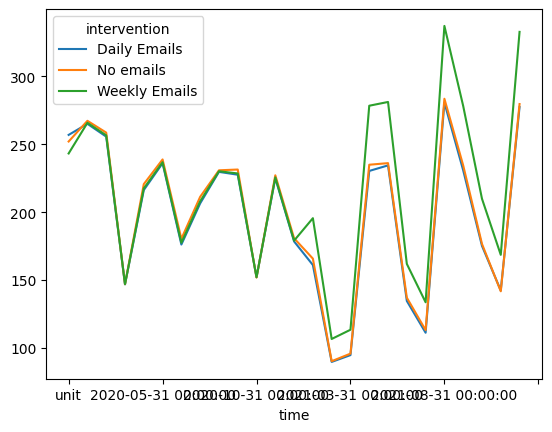

In [45]:
pivot_table.groupby("intervention").mean().T.plot()

In [46]:
pre_df = pivot_table.iloc[:,:15]
pre_df.loc[:,"intervention"] = "No emails"

post_df = pivot_table.drop(pivot_table.columns[3:15], axis = "columns")



In [47]:
pre_df.head()

time,unit,intervention,metric,2020-01-31 00:00:00,2020-02-29 00:00:00,2020-03-31 00:00:00,2020-04-30 00:00:00,2020-05-31 00:00:00,2020-06-30 00:00:00,2020-07-31 00:00:00,2020-08-31 00:00:00,2020-09-30 00:00:00,2020-10-31 00:00:00,2020-11-30 00:00:00,2020-12-31 00:00:00
0,0,No emails,monthly_sales,399.232,391.214,196.618,341.062,356.190,279.054,332.101,334.982,350.881,200.659,334.802,262.989
1,1,No emails,monthly_sales,362.223,351.296,185.235,299.002,321.044,241.805,287.672,307.819,311.809,190.999,303.691,236.987
2,2,No emails,monthly_sales,261.200,239.656,157.641,174.815,220.329,131.397,156.891,236.045,195.785,168.516,216.549,161.205
3,3,No emails,monthly_sales,191.768,194.308,106.962,188.065,183.132,164.283,186.553,162.244,189.698,106.819,170.501,147.727
4,4,No emails,monthly_sales,175.044,166.654,114.668,134.928,149.132,116.350,132.656,158.618,136.941,116.393,147.991,118.016


In [48]:
post_df.head()

time,unit,intervention,metric,2021-01-31 00:00:00,2021-02-28 00:00:00,2021-03-31 00:00:00,2021-04-30 00:00:00,2021-05-31 00:00:00,2021-06-30 00:00:00,2021-07-31 00:00:00,2021-08-31 00:00:00,2021-09-30 00:00:00,2021-10-31 00:00:00,2021-11-30 00:00:00,2021-12-31 00:00:00
0,0,Weekly Emails,monthly_sales,276.342,121.658,149.552,379.422,368.187,208.780,174.853,436.167,372.492,270.464,186.320,427.128
1,1,Daily Emails,monthly_sales,198.701,86.271,106.621,281.830,280.376,151.045,124.826,332.163,278.771,202.755,141.387,326.528
2,2,Weekly Emails,monthly_sales,161.208,86.822,99.083,236.826,251.253,133.474,111.578,292.972,239.497,183.900,143.898,291.316
3,3,Daily Emails,monthly_sales,159.405,111.115,100.591,202.285,187.093,142.323,120.929,232.026,198.895,155.834,144.939,226.606
4,4,No emails,monthly_sales,103.012,64.683,72.892,142.201,151.817,88.554,78.086,171.364,144.004,116.164,94.017,170.909


In [49]:
pre_df.to_csv("../../Synthetic-Interventions/data/sales_syn_example_pre_df.csv", index = False)
post_df.to_csv("../../Synthetic-Interventions/data/sales_syn_example_post_df.csv", index = False)

In [50]:
df.head()

,unit_id,time,age,promotional emails_0,promotional emails_1,promotional emails_2,total value of orders_0,total value of orders_1,total value of orders_2
0,0,2020-01-31,15-25,No emails,Daily Emails,Weekly Emails,399.232,344.009,419.161
1,0,2020-02-29,15-25,No emails,Daily Emails,Weekly Emails,391.214,338.308,415.345
2,0,2020-03-31,15-25,No emails,Daily Emails,Weekly Emails,196.618,175.041,212.062
3,0,2020-04-30,15-25,No emails,Daily Emails,Weekly Emails,341.062,291.185,367.748
4,0,2020-05-31,15-25,No emails,Daily Emails,Weekly Emails,356.190,294.139,367.540


In [51]:
df_all = pd.DataFrame()
for i, intervention in enumerate(["No emails","Daily Emails","Weekly Emails"]):
    pivot_table = df.pivot(index = "unit_id", columns = "time", values = f"total value of orders_{i}")
    pivot_table["intervention"] = intervention
    pivot_table["unit"] = pivot_table.index
    pivot_table["metric"] = "monthly_sales"
    pivot_table = pivot_table[["unit", "intervention", "metric"] + list(pivot_table.columns[:-3])]
    pivot_table = pivot_table.reset_index()
    pivot_table = pivot_table.drop("unit_id", axis = "columns")
    pivot_table = pivot_table.drop(pivot_table.columns[3:15], axis = "columns")
    df_all = pd.concat([df_all, pivot_table])

/var/folders/jg/bh57brfs2_985glc7khw9sch0000gn/T/ipykernel_12637/1030530273.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivot_table = df.pivot(index = "unit_id", columns = "time", values = f"total value of orders_{i}")
/var/folders/jg/bh57brfs2_985glc7khw9sch0000gn/T/ipykernel_12637/1030530273.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivot_table = df.pivot(index = "unit_id", columns = "time", values = f"total value of orders_{i}")
/var/folders/jg/bh57brfs2_985glc7khw9sch0000gn/T/ipykernel_12637/1030530273.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivot_table = df.pivot(index = "unit_id", columns = "time", values = f"total value of orders_{i}")


In [52]:
df_all.to_csv("../../Synthetic-Interventions/data/sales_syn_example_all_cfs.csv", index = False)
df_all.head()

time,unit,intervention,metric,2021-01-31 00:00:00,2021-02-28 00:00:00,2021-03-31 00:00:00,2021-04-30 00:00:00,2021-05-31 00:00:00,2021-06-30 00:00:00,2021-07-31 00:00:00,2021-08-31 00:00:00,2021-09-30 00:00:00,2021-10-31 00:00:00,2021-11-30 00:00:00,2021-12-31 00:00:00
0,0,No emails,monthly_sales,252.161,115.112,129.196,359.765,351.727,196.359,158.317,428.164,355.426,256.444,190.203,419.881
1,1,No emails,monthly_sales,219.099,104.723,114.892,318.246,317.413,174.364,140.081,385.693,316.548,231.065,176.896,379.514
2,2,No emails,monthly_sales,118.621,70.123,70.652,196.238,220.634,106.390,83.229,264.272,203.283,157.110,136.561,264.891
3,3,No emails,monthly_sales,155.274,92.860,98.139,192.969,178.968,127.976,112.332,211.603,188.064,145.078,116.035,206.339
4,4,No emails,monthly_sales,103.012,64.683,72.892,142.201,151.817,88.554,78.086,171.364,144.004,116.164,94.017,170.909
